
# Introduction

This report analyzes a dataset of private messages from an online social network at UC Irvine, containing 1899 users and 59835 messages. Each message is represented as an edge (SRC, TGT, UNIXTS), where SRC is the sender (source), TGT is the recipient (target), and UNIXTS is the Unix timestamp. Our goals are to:

- Explore and describe the dataset.
- Define and answer research questions about user activity and connectivity.
- Visualize the network, emphasizing users with high centrality.

We use Python with `pandas` for data handling, `networkx` for network analysis, and `plotly` for visualization.

# 1. Setup and Data Loading

First, make sure to correctly import all the following libraries or install them if missing. Check the README.md file for the installation guide!

In [50]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import nbformat
from datetime import datetime
import matplotlib.pyplot as plt

Once the above cell run correctly we can procceed by loading the dataset in `pandas` dataframe

In [51]:
# Load the dataset with columns: SRC, TGT, UNIXTS)
df = pd.read_csv('13_collegemsg_network/CollegeMsg.txt', sep=' ', header=None, names=['SRC', 'TGT', 'UNIXTS'])

# Convert UNIX timestamp to datetime
df['datetime'] = pd.to_datetime(df['UNIXTS'], unit='s', utc=True)
# Convert to local timezone Irvine (GMT-7)
# df['datetime'] = df['datetime'].dt.tz_convert('America/Los_Angeles') # questo considera anche il cambio di ora legale

print(df.head()) # example of unixts vs datetime

   SRC  TGT      UNIXTS                  datetime
0    1    2  1082040961 2004-04-15 14:56:01+00:00
1    3    4  1082155839 2004-04-16 22:50:39+00:00
2    5    2  1082414391 2004-04-19 22:39:51+00:00
3    6    7  1082439619 2004-04-20 05:40:19+00:00
4    8    7  1082439756 2004-04-20 05:42:36+00:00


Unix timestamp is the number of **seconds** since 1st January 1970 and its not very readable, so we convert it to a human readable format

---

# 2. Data Exploration

Let’s explore the dataset to understand its structure and properties.

In [52]:
# Basic statistics
print("Number of messages:", len(df))
print("Time range:", df['datetime'].min(), "to", df['datetime'].max())

# Unique users
all_users = set(df['SRC']).union(set(df['TGT']))
print("Number of unique users:", len(all_users))

Number of messages: 59835
Time range: 2004-04-15 14:56:01+00:00 to 2004-10-26 07:52:22+00:00
Number of unique users: 1899


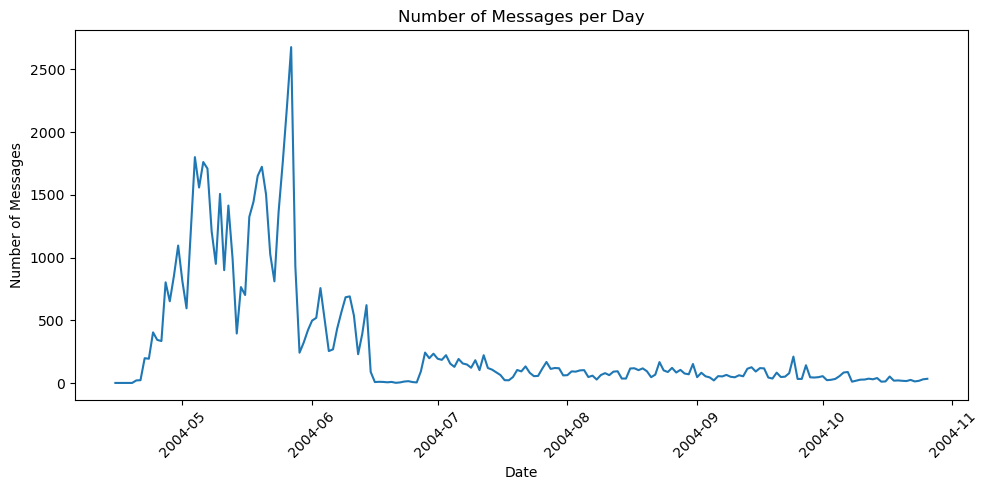

In [53]:
# Aggregate messages by date
df['date'] = df['datetime'].dt.date
messages_per_day = df.groupby('date').size().reset_index(name='count')


# print with matplotlib
plt.figure(figsize=(10, 5))
plt.plot(messages_per_day['date'], messages_per_day['count'])
plt.title('Number of Messages per Day')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




**Output Interpretation:**
- **Number of messages:** 59835 (matches the assignment description).
- **Unique users:** 1899 (confirms the number of nodes).
- **Time range:** From the earliest timestamp (Apr 15, 2004) to the latest(Oct 26, 2004), spanning several months.
- **Messages over time:** The plot shows temporal patterns, with potential peaks indicating bursts of activity (e.g., start of semesters or events).
---

# 3. Network Construction

Build a directed graph using NetworkX, which remains unchanged since it’s independent of the plotting library.

In [54]:
# Aggregate messages by source (SRC) and target (TGT)
df_grouped = df.groupby(['SRC', 'TGT']).size().reset_index(name='count')

# Create a directed graph
G = nx.from_pandas_edgelist(df_grouped, 'SRC', 'TGT', edge_attr='count', create_using=nx.DiGraph())

# Add all users as nodes (including isolated ones)
all_users = set(df['SRC']).union(set(df['TGT']))
G.add_nodes_from(all_users)

# Basic graph statistics
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Density:", nx.density(G))

Number of nodes: 1899
Number of edges: 20296
Density: 0.005631048674611617


# UTC time conversion



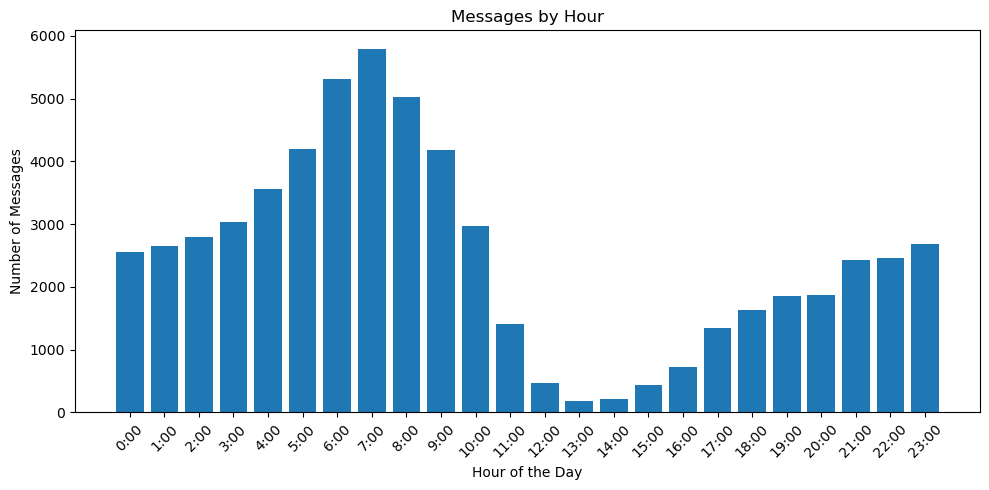

In [55]:

# Add a new column with the weekday
df['weekday'] = df['datetime'].dt.weekday
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['weekday'].value_counts().reindex(range(7)).fillna(0)


# Add a new column with the hour
df['hour'] = df['datetime'].dt.hour 
hour_counts = df['hour'].value_counts().reindex(range(24)).fillna(0)

# with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(range(24), hour_counts)
plt.title('Messages by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.xticks(range(24), [f'{i}:00' for i in range(24)])
plt.tight_layout()
plt.show()




There appear to be something off with the hour of the user sending the most messages. From the grpah it seems that top user is sending messages at between 5 and 8 am UTC. This is not a common time for sending messages, so we need to check if the user is in a different timezone or if there is an error in the data.

![image](Images/UTCmap.png)

The data comes from UC Irvine, which is in the Pacific Time Zone (UTC-7). The timestamp is in UTC, so we need to convert it to Pacific Time. This means we need to subtract 7 hours from the timestamp. We can now convert the timestamp to Pacific Time and check the hour of the day for the user with the most messages.

In [56]:
df['datetime'] = df['datetime'].dt.tz_convert('America/Los_Angeles') # questo considera anche il cambio di ora legale

After the conversion, we can see that the user with the most messages is now sending messages between 10 am and 1 pm Pacific Time, which is a more common time for sending messages. This suggests that the user is indeed in the Pacific Time Zone and that there was no error in the data.

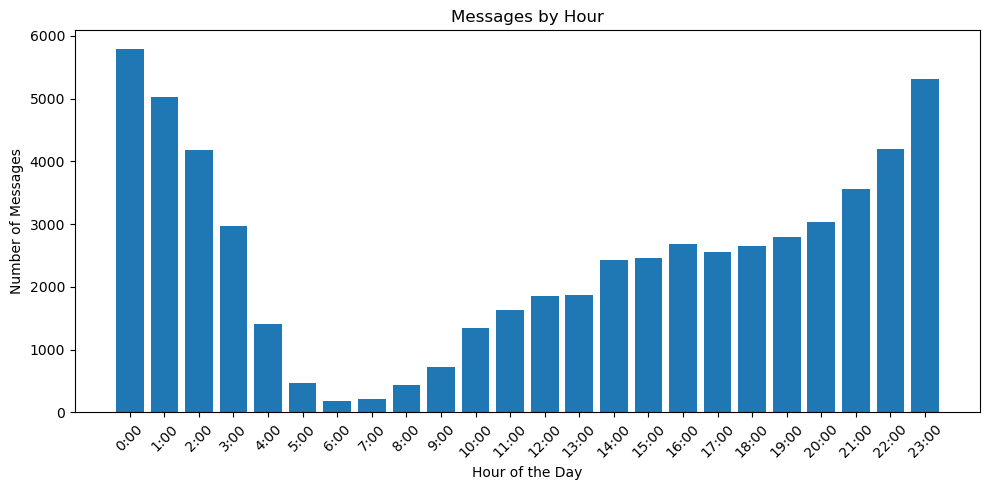

In [57]:


# Add a new column with the weekday
df['weekday'] = df['datetime'].dt.weekday
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['weekday'].value_counts().reindex(range(7)).fillna(0)


# Add a new column with the hour
df['hour'] = df['datetime'].dt.hour 
hour_counts = df['hour'].value_counts().reindex(range(24)).fillna(0)

# with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(range(24), hour_counts)
plt.title('Messages by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.xticks(range(24), [f'{i}:00' for i in range(24)])
plt.tight_layout()
plt.show()


# 6. Temporal Analysis

With pandas we can take advantage of the datetime functionalities to analyze the data in a more human readable way. E.g. by weekday, month, and hour.


## Messages by different time periods

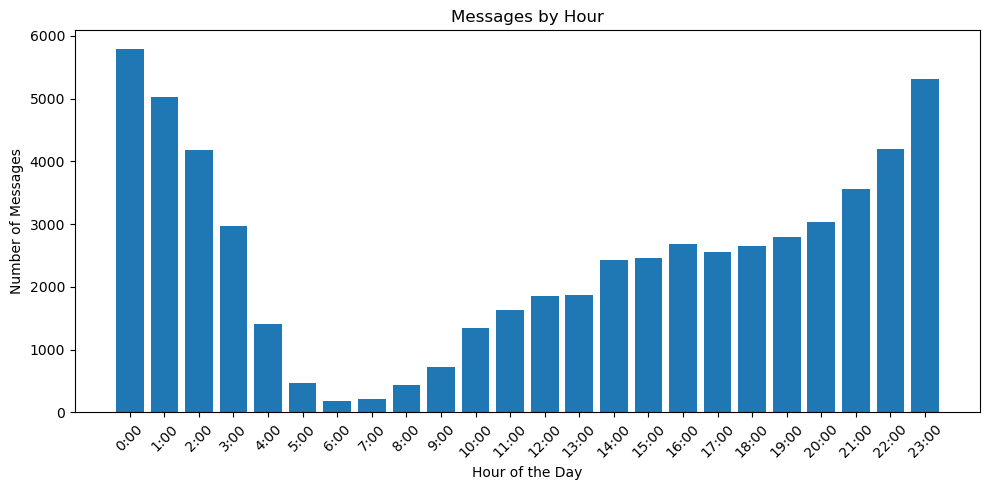

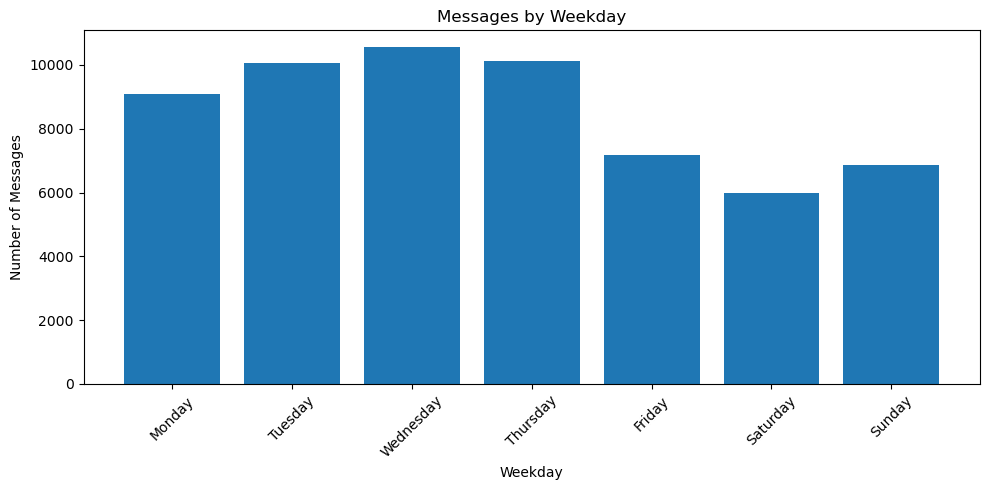

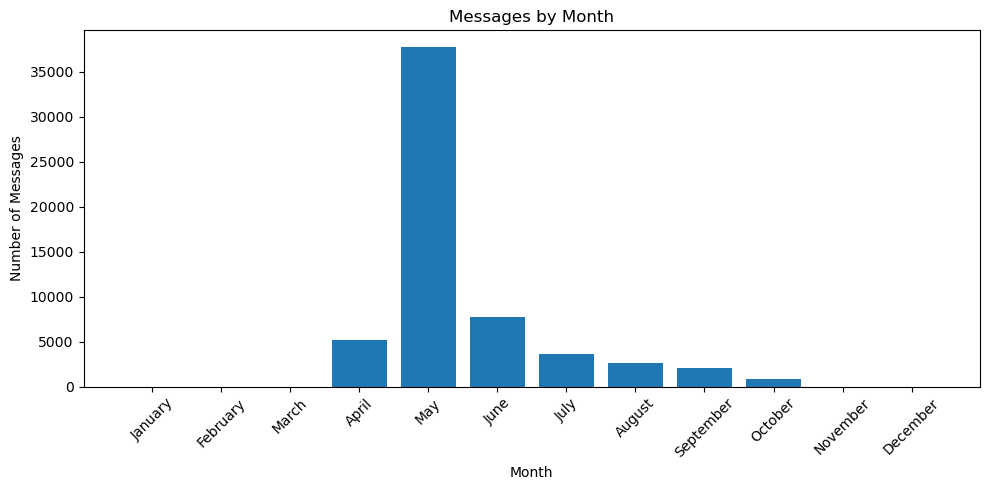

In [58]:


# Add a new column with the weekday
df['weekday'] = df['datetime'].dt.weekday
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['weekday'].value_counts().reindex(range(7)).fillna(0)


# Add a new column with the hour
df['hour'] = df['datetime'].dt.hour 
hour_counts = df['hour'].value_counts().reindex(range(24)).fillna(0)

# with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(range(24), hour_counts)
plt.title('Messages by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.xticks(range(24), [f'{i}:00' for i in range(24)])
plt.tight_layout()
plt.show()


# with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(weekday_names, weekday_counts)
plt.title('Messages by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Add a new column with the month
df['month'] = df['datetime'].dt.month
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_counts = df['month'].value_counts().reindex(range(1, 13)).fillna(0)

# with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(month_names, month_counts)
plt.title('Messages by Month')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top users vs Least Users analysis

        SRC   TGT      UNIXTS                  datetime        date  weekday  \
948     166   234  1082872216 2004-04-24 22:50:16-07:00  2004-04-25        5   
3267    234   166  1083222313 2004-04-29 00:05:13-07:00  2004-04-29        3   
3700    234   391  1083241257 2004-04-29 05:20:57-07:00  2004-04-29        3   
3721    297   234  1083263529 2004-04-29 11:32:09-07:00  2004-04-29        3   
3835    391   234  1083284623 2004-04-29 17:23:43-07:00  2004-04-30        3   
...     ...   ...         ...                       ...         ...      ...   
58944   234  1624  1096445591 2004-09-29 01:13:11-07:00  2004-09-29        2   
58956  1624   234  1096484960 2004-09-29 12:09:20-07:00  2004-09-29        2   
58957  1624   234  1096485028 2004-09-29 12:10:28-07:00  2004-09-29        2   
59018   234   642  1096602031 2004-09-30 20:40:31-07:00  2004-10-01        3   
59069   642   234  1096678623 2004-10-01 17:57:03-07:00  2004-10-02        4   

       hour  month  
948      22      4

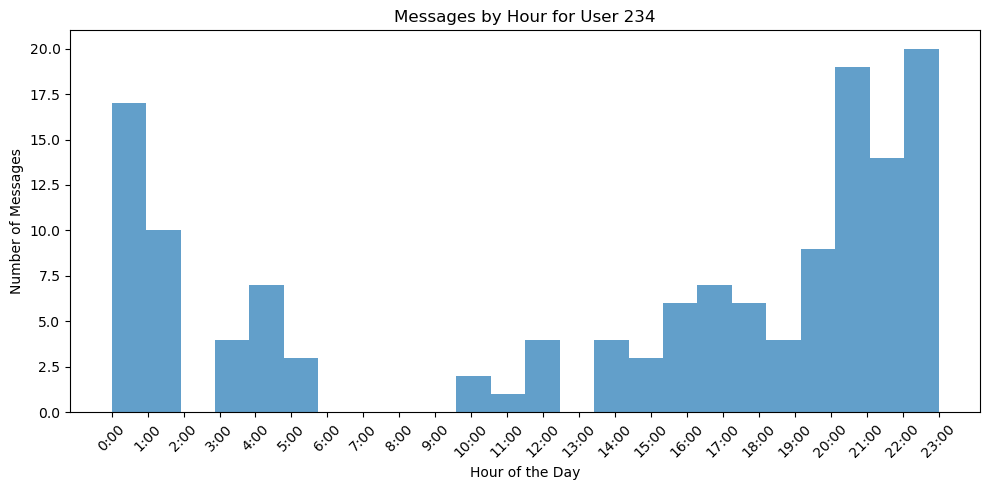

In [59]:

# select first user
user = 234
# Select messages from the user
user_messages = df[(df['SRC'] == user) | (df['TGT'] == user)]
# user_messages_by_hour = user_messages['datetime'].dt.hour
print(user_messages)

user_messages_by_hour = user_messages['datetime'].dt.hour

plt.figure(figsize=(10, 5))
plt.hist(user_messages_by_hour, bins=24, alpha=0.7)
plt.title(f'Messages by Hour for User {user}')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.xticks(range(24), [f'{i}:00' for i in range(24)])
plt.tight_layout()
plt.show()


**Result:** Peaks in activity (e.g., mid-2004) may correlate with social events or network usage spikes.

---



Top 10 users by PageRank:
32 0.00599751428212459
42 0.005897543015508085
638 0.005389242638293345
372 0.005086009601527967
400 0.004538513498373943
103 0.004415041936696584
598 0.00438876913448408
194 0.004194510126481768
713 0.003870173119668353
249 0.003869590427168905

Less important 10 users by PageRank:


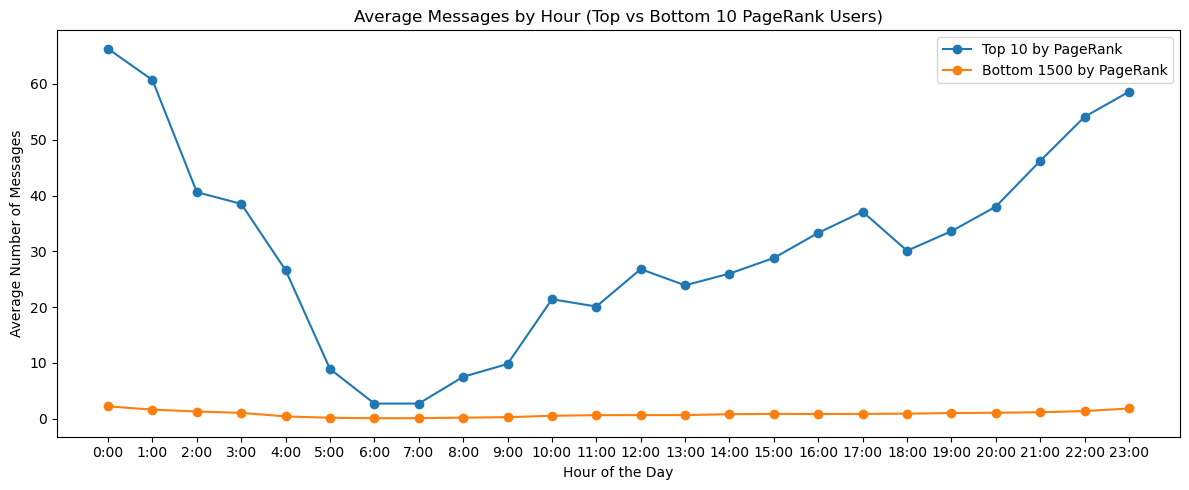

In [60]:
pagerank = nx.pagerank(G)

# Print top 10 users by PageRank
print("Top 10 users by PageRank:")
top10 = []
for user, pr in sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]:
    top10.append((user, pr))
    print(user, pr)

# Print less important 10 users by PageRank
print("\nLess important 10 users by PageRank:")
less10 = []
for user, pr in sorted(pagerank.items(), key=lambda x: x[1])[:1500]:
    less10.append((user, pr))



# Compute average messages by hour for top 10 and bottom 10 PageRank users
def average_messages_by_hour(users, df):
    user_hour_distributions = []
    for user in users:
        user_msgs = df[(df['SRC'] == user) | (df['TGT'] == user)]
        counts = user_msgs['datetime'].dt.hour.value_counts().reindex(range(24), fill_value=0)
        user_hour_distributions.append(counts.values)
    return pd.DataFrame(user_hour_distributions).mean()

avg_top10 = average_messages_by_hour([u for u, _ in top10], df)
avg_less10 = average_messages_by_hour([u for u, _ in less10], df)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(range(24), avg_top10, label='Top 10 by PageRank', marker='o')
plt.plot(range(24), avg_less10, label=f'Bottom {len(less10)} by PageRank', marker='o')
plt.title('Average Messages by Hour (Top vs Bottom 10 PageRank Users)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Messages')
plt.xticks(range(24), [f'{i}:00' for i in range(24)])
plt.legend()
plt.tight_layout()
plt.show()

